<a href="https://colab.research.google.com/github/Kimuramoro/IST407_final/blob/main/IST407_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mlxtend

<ipython-input-23-57ea8df60ce8>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_water['StreamDensity'] = Density['StreamDensity']
<ipython-input-23-57ea8df60ce8>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_water['HUC8'] = merge_water['HUC8'].astype(int)


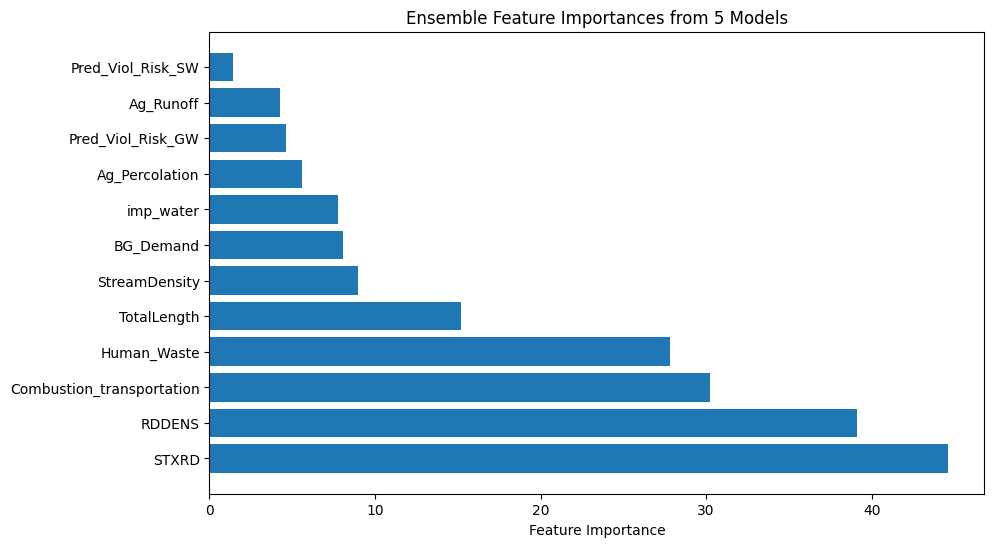

<ipython-input-23-57ea8df60ce8>:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_y['HUC8'] = test_y['HUC8'].astype(str).apply(lambda x: '0' + x if len(str(x)) == 7 else x).str[:2]


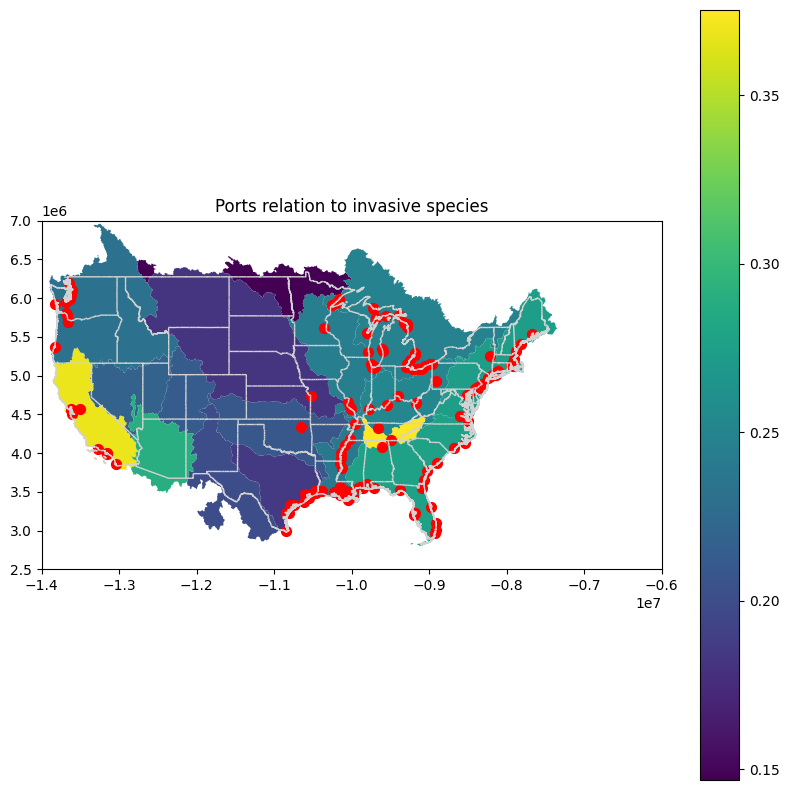

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-23-57ea8df60ce8>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['PointsCount'] += additional_scores


In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier

def print_columns_with_na(df):
#shows what  columns have na values
    columns_with_na = df.columns[df.isna().any()].tolist()

    if columns_with_na:
        print("Columns with NaN values:")
        for column in columns_with_na:
            print(column)
    else:
        print("No columns with NaN values found.")

def ensemble_feature_importance(X,y):
#use ensemble methods to plot features by importance
  skb = SelectKBest(f_regression, k = 'all')
  rf = RandomForestRegressor(n_estimators=100, random_state=42)
  gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
  ab = AdaBoostRegressor(n_estimators=100, random_state=42)
  lr = LinearRegression()
  rfe = RFE(lr, n_features_to_select=1)

  # Fit models

  rf.fit(X, y)
  gb.fit(X, y)
  ab.fit(X, y)
  rfe.fit(X, y)
  skb.fit_transform(X, y)

  # Get feature importances from each model
  rf_fi = rf.feature_importances_
  gb_fi = gb.feature_importances_
  ab_fi = ab.feature_importances_
  rfe_fi = rfe.ranking_
  skb_fi = skb.scores_[skb.get_support()]


  # Average the feature importance scores across models
  ensemble_feature_importance = (skb_fi + rfe_fi + rf_fi + gb_fi + ab_fi) / 5

  # Pair feature names with their importances
  feature_names = X.columns
  feature_importance_dict = dict(zip(feature_names, ensemble_feature_importance))

  # Sort features by importance
  sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

  # Print feature importance with names
  #for feature, importance in sorted_features:
  #    print(f"Feature: {feature}, Importance: {importance}")


  # Plot feature importances
  features, importance = zip(*sorted_features)
  plt.figure(figsize=(10, 6))
  plt.barh(range(len(importance)), importance, align='center')
  plt.yticks(range(len(features)), features)
  plt.xlabel('Feature Importance')
  plt.title('Ensemble Feature Importances from 5 Models')
  plt.show()


def joiner(df):
#converts huc12 to huc8 values then groups by huc8 before converting huc8 back to an int
  df['HUC_12'] = df['HUC_12'].astype(str).str[:8]
  grouped_df = df.groupby('HUC_12').mean().reset_index()
  MERGE_df = grouped_df.rename(columns={'HUC_12': 'HUC8'})
  MERGE_df['HUC8'] = MERGE_df['HUC8'].astype(int)
  return MERGE_df


def divide_by_y(row):
#used for the water df. divides every column by the total length to get proportion of total river that is impaired by feature (turbidity, bacteria, excess nitrogen, etc)
    return row.iloc[:-1] / row['TotalLength']

def is_8_or_6(num):
    return num in [8, 6]

datapt1 = pd.read_csv('./MASTER_wPriorityIndex_HUC8_v3.csv')
#y value(priority index) reflects the priority for conservation for each watershed. vulnerability is determined by dividing # of invasive species by # of native species,
#then adjusted based on value of conservation for that watershed
Priority_Index = datapt1[['HUC8','PriorityIndex']]

#reading and merging of potentially significant features in predicting priority index
nitrogen = pd.read_excel('./National_Nitrogen_Inventory (1).xlsx', '2012')
roads = pd.read_csv('./RoadsNearStreams.csv')
runoff = pd.read_csv('./N_P_H2O_Loss.csv')
drink = pd.read_csv('./DrinkingWaterNitratePredictions_CONUS.csv')
hunt = pd.read_csv('/content/BigGameHunting_RecreationDemand.csv')
water = pd.read_csv('./ImpairedWaters.csv')


nitrogen = nitrogen.rename(columns = {'HUC8_1':'HUC8'})
merge_nit = nitrogen[['HUC8','Combustion_transportation','Human_Waste']]
#features: pollution from cars, human waste as proxy for amount of people living by watershed

joined_roads = joiner(roads)
merge_roads = joined_roads[['HUC8','STXRD','RDDENS']]
#features: STXRD -> how many roads go over streams, RDDENS -> density of roads in that watershed

joined_run = joiner(runoff)
merge_run = joined_run[['HUC8','Ag_Percolation','Ag_Runoff']]
#features: Ag_percolation -> how much water percolates through farmland into groundwater resevoir, Ag_runoff -> estimated surface runoff from farmland(water with excess Nitrogen & Phosphorous)

drink = drink.replace('None',0).astype(float)
joined_drink = joiner(drink)
merge_drink = joined_drink[['HUC8','Pred_Viol_Risk_GW','Pred_Viol_Risk_SW']]
#features: predicted risk for violation for groundwater and surfacewater. how likely that these areas recieve violations for having excess Nirogen or Phosphorus in their drinking water

merge_hunt = joiner(hunt)
#featuers: demand for big game hunting

water['HUC_12'] = water['HUC_12'].astype(str).str[:8]
grouped_water = water.groupby('HUC_12').sum().reset_index().rename(columns={'HUC_12': 'HUC8'})
Density = water.groupby('HUC_12').mean().reset_index()
tester = grouped_water.drop(['WaterbodyArea','StreamDensity'], axis=1)
tot_imp = tester.drop('HUC8', axis=1).apply(divide_by_y, axis=1).sum(axis=1)
grouped_water['imp_water'] = tot_imp
merge_water = grouped_water[['HUC8','imp_water','TotalLength','StreamDensity']]
merge_water['StreamDensity'] = Density['StreamDensity']
merge_water['HUC8'] = merge_water['HUC8'].astype(int)
#features: proportion of overall length of river has been impaired. impairment includes; mercury & other metals, turbidity, nuisance species, pesticides, pathogens, depleted/excess o2,
#turbidity, temperature. one feature acts as catch all for total lecel of impairment. other features are total length of river and density

#merging all features
m1 = pd.merge(Priority_Index, merge_roads, on='HUC8')
m2 = pd.merge(m1, merge_drink, on='HUC8')
m3 = pd.merge(m2, merge_hunt, on='HUC8')
m4 = pd.merge(m3, merge_nit, on='HUC8')
m5 = pd.merge(m4, merge_water, on='HUC8')
m6 = pd.merge(m5, merge_run, on='HUC8')
mx = m6

#scaling mx
scaler = StandardScaler()
master_db = pd.DataFrame(scaler.fit_transform(mx), columns= mx.columns)
master_db[['HUC8','PriorityIndex']] = m5[['HUC8','PriorityIndex']]


#split into X,y then run through ensemble voting to get feature importance
X = master_db.drop(['HUC8','PriorityIndex'],axis=1)
y = master_db['PriorityIndex']

ensemble_feature_importance(X,y)


#MAPPING STARTS HERE
test_y = Priority_Index

test_y['HUC8'] = test_y['HUC8'].astype(str).apply(lambda x: '0' + x if len(str(x)) == 7 else x).str[:2]
huc2_y= test_y.groupby('HUC8').mean().reset_index().rename(columns={'HUC8':'HUC2'})


gdf = gpd.read_file("/content/Watershed_Boundary_Dataset_HUC_2s (1).zip")
merged_gdf = gdf.merge(huc2_y, how='left', left_on='HUC2', right_on='HUC2')
us_states = gpd.read_file('/content/State_Lines_by_Type.zip')
ports = gpd.read_file('/content/USDOT_MARAD_Ports_TypologyDesc_OPS (1).zip')

fig, ax = plt.subplots(figsize=(10, 10))  # Create a Matplotlib figure and axis
us_states.plot(ax=ax, color='lightgrey', linewidth=1)  # Plot state boundaries
merged_gdf.plot(ax=ax, column='PriorityIndex', cmap='viridis', legend=True)

ports.plot(ax=ax, color='red', marker='o', markersize=50)

ax.set_xlim(-1.4e7, -0.6e7)  # Set the x-axis limits
ax.set_ylim(0.25e7, 0.7e7)

plt.title('Ports relation to invasive species')  # Set the title for the plot
plt.show()  # Show the plot

#determines the amount of ports that exist upstream of a huc2 region. This situation only impacts the mississipi(08) and #tennessee (06)
#basins because of the mississipi river. I added the count of ports in watersheds above regions 6 and 8 to their sum of ports.
#this was the only way I could work it out but if i was smarter I would make a polygon of the river systems in a us with their flow, and
#count how many port plots are updtream of each huc2 boundary. but this was easier, and only applicable in one cirumstance of multi basin
#river systems
join = sjoin(merged_gdf, ports, how='left', op='contains')
join['HUC2'] = join['HUC2'].astype(int)
count_points_within_polygons = join.groupby('HUC2').size().reset_index(name='PointsCount')
count = count_points_within_polygons

# Filter rows where number is 8 or 6
filtered = count[count['HUC2'].apply(is_8_or_6)]
additional_scores = count[count['HUC2'].isin([4, 5, 7, 10])]['PointsCount'].sum()
filtered['PointsCount'] += additional_scores

# Update the original DataFrame with modified scores
count.update(filtered)

merged_gdf['HUC2'] = merged_gdf['HUC2'].astype(int)
merged_gdf_ports = merged_gdf.merge(count, how='left', left_on='HUC2', right_on='HUC2')

In [ ]:
correlation = merged_gdf_ports['PriorityIndex'].corr(merged_gdf_ports['PointsCount'])

print(f"The correlation coefficient between (Priority Index) and (# of shipping ports upstream) is: {correlation}")


The correlation coefficient between (Priority Index) and (# of shipping ports upstream) is: 0.40115346919904254


In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
#shows the features used to produce our highest r^2 value of .68
# Create a Gradient Boosting Regressor
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

#were doing an exhaustive feature selection for gradient boost because that was the best standalone model
efs = ExhaustiveFeatureSelector(gb, min_features=1, max_features=12, scoring='r2', cv=None)

# Fit Exhaustive Feature Selector
efs = efs.fit(X, y)

# Get selected feature subsets
selected_features = list(efs.best_feature_names_)

# Get performance of the best subset
best_score = efs.best_score_

# Print selected features and their performance
print("Selected Features:", selected_features)
print("Best Score (R^2):", best_score)

Features: 4095/4095

Selected Features: ['STXRD', 'RDDENS', 'Pred_Viol_Risk_GW', 'Pred_Viol_Risk_SW', 'Combustion_transportation', 'Human_Waste', 'imp_water', 'TotalLength', 'StreamDensity', 'Ag_Percolation', 'Ag_Runoff']
Best Score (R^2): 0.6843319930389069


<ipython-input-29-17f7816b56ff>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_y['HUC8'] = test_y['HUC8'].astype(str).apply(lambda x: '0' + x if len(str(x)) == 7 else x).str[:2]


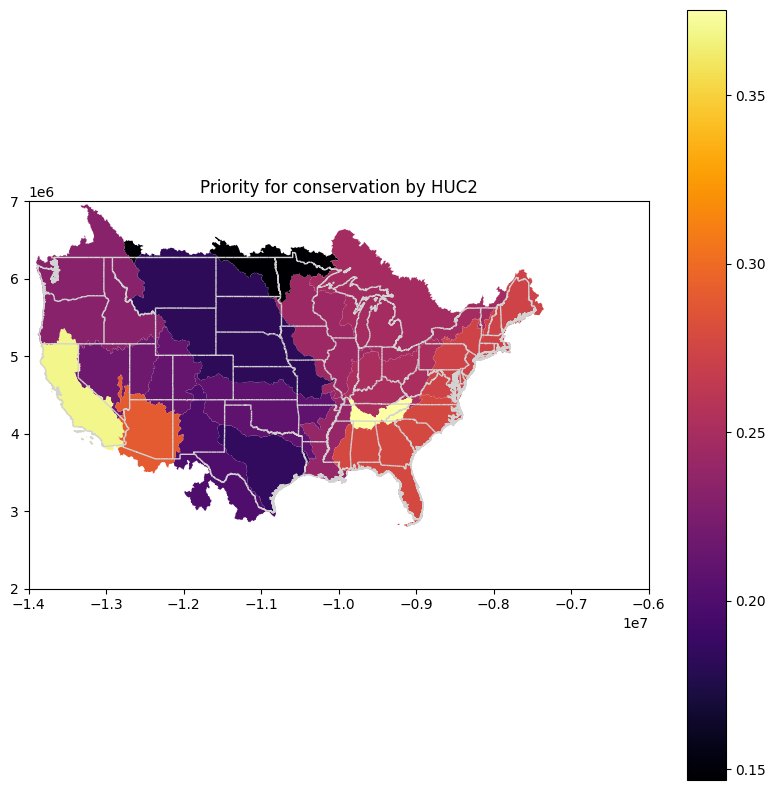

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

test_y = Priority_Index

test_y['HUC8'] = test_y['HUC8'].astype(str).apply(lambda x: '0' + x if len(str(x)) == 7 else x).str[:2]
huc2_y= test_y.groupby('HUC8').mean().reset_index().rename(columns={'HUC8':'HUC2'})


gdf = gpd.read_file("/content/Watershed_Boundary_Dataset_HUC_2s (1).zip")
merged_gdf = gdf.merge(huc2_y, how='left', left_on='HUC2', right_on='HUC2')
us_states = gpd.read_file('/content/State_Lines_by_Type.zip')


fig, ax = plt.subplots(figsize=(10, 10))  # Create a Matplotlib figure and axis
us_states.plot(ax=ax, color='lightgrey', linewidth=1)  # Plot state boundaries
merged_gdf.plot(ax=ax, column='PriorityIndex', cmap='inferno', legend=True)
ax.set_xlim(-1.4e7, -0.6e7)  # Set the x-axis limits
ax.set_ylim(0.2e7, 0.7e7)

plt.title('Priority for conservation by HUC2')  # Set the title for the plot
plt.show()  # Show the plot


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train_embedded, X_test_embedded, y_train, y_test = train_test_split(X, y, random_state=42)
# Create Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Create Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the individual models
rf_regressor.fit(X_train_embedded, y_train)
gb_regressor.fit(X_train_embedded, y_train)

# Make predictions on the test set
y_pred_rf_embedded = rf_regressor.predict(X_test_embedded)
y_pred_gb_embedded = gb_regressor.predict(X_test_embedded)

# Ensemble predictions (average)
y_pred_ensemble_embedded = (y_pred_rf_embedded + y_pred_gb_embedded) / 2

# Evaluate the ensemble model
mse_ensemble_embedded = mean_squared_error(y_test, y_pred_ensemble_embedded)
rmse_ensemble_embedded = np.sqrt(mse_ensemble_embedded)
r2 = r2_score(y_test, y_pred_ensemble_embedded)

print(f'Ensemble Mean Squared Error: {mse_ensemble_embedded}')
print(f'Ensemble Root Mean Squared Error: {rmse_ensemble_embedded}')
print(f'R-squared Score: {r2}')

Ensemble Mean Squared Error: 0.006165245734910412
Ensemble Root Mean Squared Error: 0.07851907879560491
R-squared Score: 0.46577122344219546


https://catalog.data.gov/dataset/enviroatlas-agricultural-buffers-by-12-digit-huc-for-the-conterminous-united-states1

https://catalog.data.gov/dataset/climate-wildfire-and-erosion-data-western-us-82eb6

https://catalog.data.gov/dataset/enviroatlas-2011-land-cover-by-12-digit-huc-for-the-conterminous-united-states1

https://catalog.data.gov/dataset/enviroatlas-thermoelectric-water-use-by-12-digit-huc-for-the-conterminous-united-states1

https://catalog.data.gov/dataset/enviroatlas-domestic-water-demand-by-12-digit-huc-for-the-conterminous-united-states1

https://catalog.data.gov/dataset/enviroatlas-road-density-metrics-by-12-digit-huc-for-the-conterminous-united-states

https://catalog.data.gov/dataset/enviroatlas-agricultural-water-demand-by-12-digit-huc-for-the-conterminous-united-states1

https://catalog.data.gov/dataset/enviroatlas-major-grains-and-cotton-by-12-digit-huc-for-the-conterminous-united-states1

+ the nitrogen one we already have somewhere up here